## SLOAN DIGITAL SKY SURVEY ANALYSIS


## Overview

#### 1- In this project, we worked on Sloan Digital Sky Survey(SDSS) sky observation data. Normally it is possible to query the SDSS database server to retrieve newest data:
http://skyserver.sdss.org/dr12/en/tools/search/sql.aspx

#### 2- But we couldn't find a package to handle this retrieval through Python(All of them are deprecated). So we decided to take data from Kaggle. You can find additional information about the data here:
https://www.kaggle.com/lucidlenn/sloan-digital-sky-survey/home

#### 3- First, we analyzed the data and did the necessary transformation, normalization on it. Then, we did some visualization and implementation of supervised algorithms to classify given data whether it is a Star, Quasar or Galaxy using many classification algorithms such as KNN, Decision Tree, SVM and LightGBM. We checked the accuracies of them.



## Data explanation:-

##### * The data is collected from the joint of 2 table. (PhotoObj ve SpecObj)
##### * PhotoObj has photometric data that is related to light.
#### * SpecObj has spectral data related to the interaction of matter and electromagnetic radiation.
#### * objid = object identifier
#### * A system, called equatorial coordinates, is used on the sky sphere based on the poles of the Earth and its equator. This system is fixed to the stars. It does not resemble horizon coordinates, so the position of a star does not depend on the observer's time. Therefore, astronomers prefer this system. In order to determine the position of an object in the sky sphere, it is necessary to first determine the angular position(ra) along the sky equator. This is coordinate rectification (right-opening/right-ascension).
#### * u,g,r,i,z are the magnitudes of the objects in the SDSS. (These represent the fluxes of light measured in logarithmic units, through various wavebands from the ultraviolet to the infrared.)
#### * run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels.
#### * redshift The wavelength of the light is stretched, so the light is seen as 'shifted' towards the red part of the spectrum.Redshift in cosmology is usually labeled as 'z'. It is unit-less because you divide the units out when you compare the observed wavelength to the known source wavelength.

In [1]:
#### Importing Libraries ####

# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
%matplotlib inline

from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold, cross_val_score,GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
### lode the date set and check the top five date in the date set 

##df_space = pd.read_csv(r"C:/Users/HP/Desktop/dataset/Space Server Dataset.csv")

df_space = pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/Skyserver.csv", sep=",")
df_space.head()                         


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


In [3]:
## check the last 5 Row of the dataset
df_space.tail()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,GALAXY,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,GALAXY,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,STAR,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,GALAXY,0.014019,447,51877,229
9999,1.237650e+18,131.665012,51.805307,19.27586,17.37829,16.30542,15.83548,15.50588,1345,301,3,163,5.033410e+17,GALAXY,0.118417,447,51877,233


In [4]:
### let's check the basic info from the dataset 

df_space.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


#### As we check ( 18columns, 10000rows ) present in the data set , here is see that dtypes: float64(10), int64(7), object(1)

In [5]:
### let's check the basic statistics of the data set 

df_space.describe()


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,1.577039e+05,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


#### As we check that no missing values present in the date set all the columns count are equal (10000), 

In [6]:
### check the missing value of the dataset column wise or total

print(" NaN value in the data set column wise :- \n " )
print(df_space.isnull().sum())
print()
print(" Total NaN value in the data set  :- \n " )
df_space.isnull().sum().sum()


## Here we find that no there in no missing value present in the data set

 NaN value in the data set column wise :- 
 
objid        0
ra           0
dec          0
u            0
g            0
r            0
i            0
z            0
run          0
rerun        0
camcol       0
field        0
specobjid    0
class        0
redshift     0
plate        0
mjd          0
fiberid      0
dtype: int64

 Total NaN value in the data set  :- 
 


0

In [7]:
# let's check the total column present in the date set 

df_space.columns.values

array(['objid', 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run', 'rerun',
       'camcol', 'field', 'specobjid', 'class', 'redshift', 'plate',
       'mjd', 'fiberid'], dtype=object)

In [8]:
df_space.nunique()

objid            1
ra           10000
dec          10000
u             9730
g             9817
r             9852
i             9890
z             9896
run             23
rerun            1
camcol           6
field          703
specobjid     6349
class            3
redshift      9637
plate          487
mjd            355
fiberid        892
dtype: int64

In [9]:
"""f, ax = plt.subplots(figsize=(20, 20))
corr = df_space.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot = True)"""

'f, ax = plt.subplots(figsize=(20, 20))\ncorr = df_space.corr()\nsns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),\n            square=True, ax=ax, annot = True)'

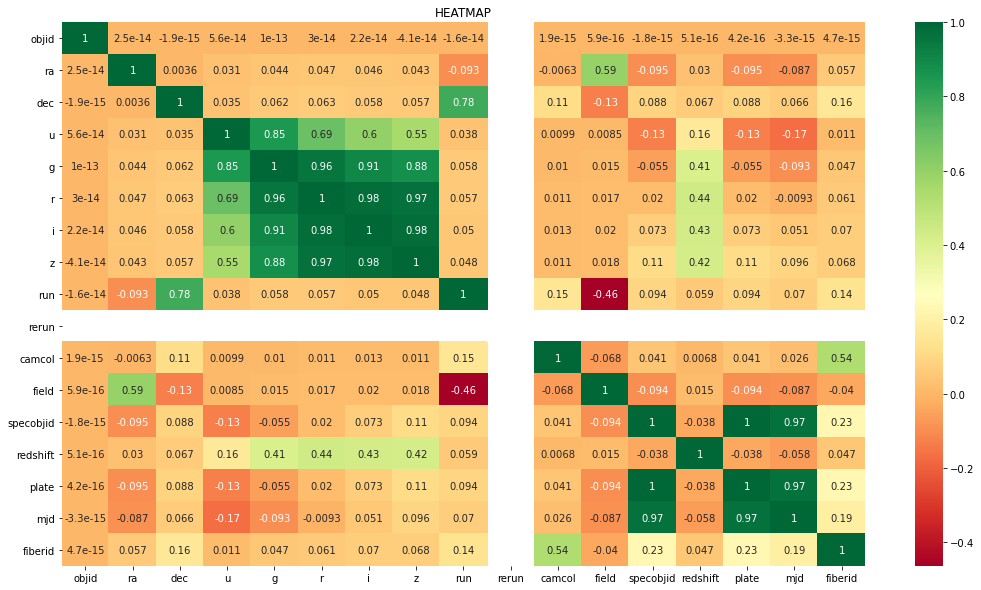

In [10]:
cor=df_space.corr()
top_corr_feature=cor.index
plt.figure(figsize=(18,10))
sns.heatmap(df_space[top_corr_feature].corr(),annot=True,cmap="RdYlGn")
plt.title("HEATMAP")
plt.show()

In [11]:
categorical_values = []
for column in df_space.columns:
    print('======================================================')
    print(f"{column} : {df_space[column].unique()}")
    if len(df_space[column].unique()) <= 10:
        categorical_values.append(column)

objid : [1.23765e+18]
ra : [183.5313257 183.5983705 183.6802074 ... 131.5525623 131.4771511
 131.6650121]
dec : [ 0.08969303  0.13528503  0.12618509 ... 51.66698638 51.75306779
 51.80530747]
u : [19.47406 18.6628  19.38298 ... 18.75818 18.88287 19.27586]
g : [17.0424  17.21449 18.19169 ... 17.77784 17.91068 17.37829]
r : [15.94699 16.67637 17.47428 ... 17.51872 17.53152 16.30542]
i : [15.50342 16.48922 17.08732 ... 17.43302 17.36284 15.83548]
z : [15.22531 16.3915  16.80125 ... 17.42048 17.13988 15.50588]
run : [ 752  756  308  727  745 1035 1045 1140 1231 1332 1334 1302 1239 1119
 1331 1345 1350 1404 1412 1336 1402 1411 1356]
rerun : [301]
camcol : [4 2 1 5 6 3]
field : [267 268 269 270 271 272 273 274 275 276 277 278 279 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 502 503
 504 505 506 508 509 510 511 512 515 516 517 518 519 520 521 522 104 105
 110 111 112 113 114 115 116  25  26  28  29  90  91  92  93  95  74  70
  71  66 103 538 539 567 568

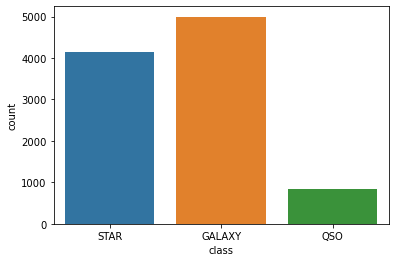

In [12]:
ax = sns.countplot(x="class", data=df_space)

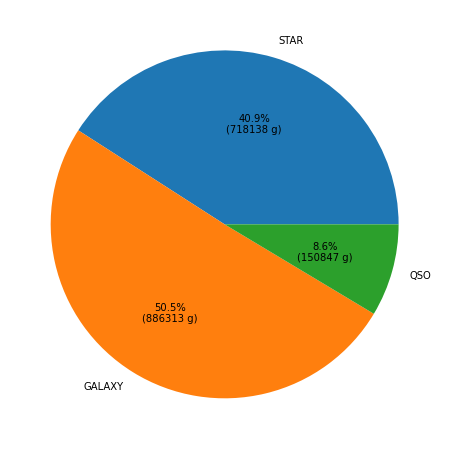

In [13]:
SSD=df_space.groupby('class')["ra"].agg('sum')
SSD

values=[SSD['STAR'],SSD['GALAXY'],SSD['QSO']]
labels=['STAR','GALAXY','QSO']


# Creating autocpt arguments 
def func(pct, allvalues): 
    absolute = int(pct / 100.*np.sum(allvalues)) 
    return "{:.1f}%\n({:d} g)".format(pct, absolute) 
  
# Creating plot 
fig = plt.figure(figsize =(10,8)) 
plt.pie(values, labels = labels,autopct = lambda pct: func(pct, values)) 
  
# show plot 
plt.show() 

In [14]:
### check the coorelation between two features
def correlation():
    att1 = input("Enter first attribute: ")
    att2 = input("Enter second attribute: ")
    print(df_space[att1].corr(df_space[att2]))
correlation()


Enter first attribute: r
Enter second attribute: g
0.9581062424641577


In [15]:
### We have to convert our class attribute to numerical variable:

def convert_to_int(x):
    if x == "STAR":
        return 1
    elif x == "GALAXY":
        return 2
    elif x == "QSO":
        return 3
    
df_space['class'] = df_space['class'].apply(lambda x: convert_to_int(x))
df_space

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,1,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,1,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,2,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,1,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,1,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.237650e+18,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,1345,301,3,161,5.033450e+17,2,0.027583,447,51877,246
9996,1.237650e+18,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,1345,301,3,162,5.033400e+17,2,0.117772,447,51877,228
9997,1.237650e+18,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,1345,301,3,162,8.222620e+18,1,-0.000402,7303,57013,622
9998,1.237650e+18,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,1345,301,3,163,5.033400e+17,2,0.014019,447,51877,229


In [16]:
## as we check objID is not important for us, we will drop it.
## The attributes that have same values in all rows also be dropped out.

In [17]:

df_space.drop(['specobjid','fiberid'],axis=1,inplace=True)
df_space.drop(['objid','rerun','camcol'],axis=1,inplace=True)
df_space.head(10)

,ra,dec,u,g,r,i,z,run,field,class,redshift,plate,mjd
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,267,1,-0.000009,3306,54922
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,267,1,-0.000055,323,51615
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,268,2,0.123111,287,52023
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,269,1,-0.000111,3306,54922
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,269,1,0.000590,3306,54922
5,183.847174,0.173694,19.43133,18.46779,18.16451,18.01475,18.04155,752,269,1,0.000315,324,51666
6,183.864379,0.019201,19.38322,17.88995,17.10537,16.66393,16.36955,752,269,2,0.100242,287,52023
7,183.900081,0.187473,18.97993,17.84496,17.38022,17.20673,17.07071,752,269,1,0.000315,3306,54922
8,183.924588,0.097246,17.90616,16.97172,16.67541,16.53776,16.47596,752,270,1,0.000089,323,51615
9,183.973498,0.081626,18.67249,17.71375,17.49362,17.28284,17.22644,752,270,2,0.040508,288,52000


In [21]:
### Machine Learning :-

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

all_accuracies = []

X = df_space.drop(['class'],axis=1)
y = df_space['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)




In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

KNN score: 0.902

KNN score: 0.8836

KNN score: 0.906

KNN score: 0.8964

KNN score: 0.9008

KNN score: 0.8956

KNN score: 0.896

KNN score: 0.8932

KNN score: 0.8932

KNN score: 0.8916

KNN score: 0.892

KNN score: 0.894

KNN score: 0.894

KNN score: 0.8928

KNN score: 0.8908

KNN score: 0.8888

KNN score: 0.888

KNN score: 0.886

KNN score: 0.886

KNN score: 0.8844

KNN score: 0.8844

KNN score: 0.8804

KNN score: 0.8796

KNN score: 0.8784



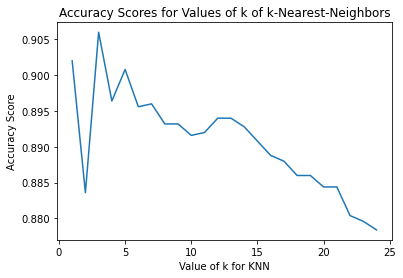

In [23]:
k_range = list(range(1,25))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k) # Choose classifier
    KNN_fit = knn.fit(X_train_scaled, y_train) # Train classifier
    accuracy = KNN_fit.score(X_test_scaled, y_test) # Estimate the accuracy of the classifier on future data
    print ('KNN score: {}\n'.format(accuracy))
    scores.append(accuracy)
    
plt.plot(k_range, scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

all_accuracies.append(max(scores))


### According to the KNN if we choose k = 4, we will get the best result of approximately 91.1%.

## Decision Tree algorithm:

In [24]:
##  let's try with a Decision Tree algorithm:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

DTC = DecisionTreeClassifier(max_depth=None).fit(X_train_scaled, y_train)
y_predicted = DTC.predict(X_test_scaled)
conf_mat = confusion_matrix(y_test, y_predicted)
print("Classification with Decision Tree Algorithm\nConfusion Matrix\n\n",conf_mat)
print('\nAccuracy:{0:.3f}\n'.format(accuracy_score(y_test, y_predicted)))
print('Classification Report: \n\n',classification_report(y_test, y_predicted))

all_accuracies.append(accuracy_score(y_test, y_predicted))

Classification with Decision Tree Algorithm
Confusion Matrix

 [[1006    4    2]
 [   5 1225   16]
 [   0   16  226]]

Accuracy:0.983

Classification Report: 

               precision    recall  f1-score   support

           1       1.00      0.99      0.99      1012
           2       0.98      0.98      0.98      1246
           3       0.93      0.93      0.93       242

    accuracy                           0.98      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.98      0.98      0.98      2500



## Support Vector Machine Algorithm`

In [25]:
## We will apply this algorithm on unnormalized data and normalized data with different kernel functions.
## (We didn't include the effect of the value of C in this tutorial but High C means low regularization which means the model tries to fit training data as well as possible.
## Oppositely, low C means high regularization that is the model will be represented more general for upcoming records.


from sklearn.svm import SVC

# For unnormalized data
SVM1_RBF_UnNorm = SVC(C=10).fit(X_train, y_train)
SVM1_Sig_UnNorm = SVC(C=10, kernel="sigmoid").fit(X_train, y_train)

# For normalized data
SVM1_RBF_Norm = SVC(C=10).fit(X_train_scaled, y_train)
SVM1_Sig_Norm = SVC(C=10, kernel="sigmoid").fit(X_train_scaled, y_train)


In [26]:
print('Accuracy of SVM on unnormalized data with C=10 and kernel function RBF: \nOn training set:{0:.3f}'.format(SVM1_RBF_UnNorm.score(X_train_scaled, y_train)),'\nOn test set: {:.3f}\n\n'.format(SVM1_RBF_UnNorm.score(X_test_scaled, y_test)))
print('Accuracy of SVM on unnormalized data with C=10 and kernel function Sigmoid: \nOn training set:{0:.3f}'.format(SVM1_Sig_UnNorm.score(X_train_scaled, y_train)),'\nOn test set: {:.3f}\n\n'.format(SVM1_Sig_UnNorm.score(X_test_scaled, y_test)))
print('Accuracy of SVM on normalized data with C=10 and kernel function RBF: \nOn training set:{0:.3f}'.format(SVM1_RBF_Norm.score(X_train_scaled, y_train)),'\nOn test set: {:.3f}\n\n'.format(SVM1_RBF_Norm.score(X_test_scaled, y_test)))
print('Accuracy of SVM on normalized data with C=10 and kernel function Sigmoid: \nOn training set:{0:.3f}'.format(SVM1_Sig_Norm.score(X_train_scaled, y_train)),'\nOn test set: {:.3f}\n\n'.format(SVM1_Sig_Norm.score(X_test_scaled, y_test)))

all_accuracies.append(SVM1_RBF_Norm.score(X_test_scaled, y_test))

Accuracy of SVM on unnormalized data with C=10 and kernel function RBF: 
On training set:0.419 
On test set: 0.405


Accuracy of SVM on unnormalized data with C=10 and kernel function Sigmoid: 
On training set:0.500 
On test set: 0.498


Accuracy of SVM on normalized data with C=10 and kernel function RBF: 
On training set:0.970 
On test set: 0.959


Accuracy of SVM on normalized data with C=10 and kernel function Sigmoid: 
On training set:0.578 
On test set: 0.573




##  LightGBM Classification ````

In [28]:
!pip3 install lightgbm

In [29]:

import lightgbm as lg

lg = lg.LGBMClassifier()
lg.fit(X_train_scaled,y_train)
predictions = lg.predict(X_test_scaled)
lg_acc = (predictions == y_test).sum().astype(float)/len(predictions)
print("Accuracy of LightGBM Classifier: ",lg_acc)

all_accuracies.append(lg_acc)

Accuracy of LightGBM Classifier:  0.9932


## Conclusion :-


<BarContainer object of 4 artists>

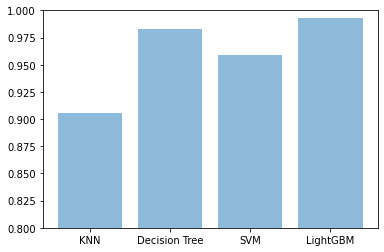

In [30]:
horizontal = ['KNN','Decision Tree','SVM','LightGBM']
plt.ylim(0.8,1.0)
plt.bar(horizontal, all_accuracies, align='center', alpha=0.5)
